In [12]:
# import cleaned data and train tensorflow nueral network




#import data
import pandas as pd
data=pd.read_csv('LoanClub10000Cleaned.csv')
UnNormData=pd.read_csv('LoanClub10000CleanedUnNorm.csv')
data=data.drop(columns="Unnamed: 0")

#split into dependent and indpendent variables data frames
x=data.drop(columns=["target"])
y=data["target"]


#using function to find optimal batch size
def FindBatchSize(model):
    """model: model architecture, that is yet to be trained"""
    import os, sys, psutil, gc, tensorflow
    import numpy as np
    BatchFound= 16

    try:
        total_params= int(model.count_params());    GCPU= "CPU"
        #find whether gpu is available
        try:
            if K.tensorflow_backend._get_available_gpus()== []:
                GCPU= "CPU";    #CPU and Cuda9GPU
            else:
                GCPU= "GPU"
        except:
            from tensorflow.python.client import device_lib;    #Cuda8GPU
            def get_available_gpus():
                local_device_protos= device_lib.list_local_devices()
                return [x.name for x in local_device_protos if x.device_type == 'GPU']
            if "gpu" not in str(get_available_gpus()).lower():
                GCPU= "CPU"
            else:
                GCPU= "GPU"

        #decide batch size on the basis of GPU availability and model complexity
        if (GCPU== "GPU") and (os.cpu_count() >15) and (total_params <1000000):
            BatchFound= 64    
        if (os.cpu_count() <16) and (total_params <500000):
            BatchFound= 64  
        if (GCPU== "GPU") and (os.cpu_count() >15) and (total_params <2000000) and (total_params >=1000000):
            BatchFound= 32      
        if (GCPU== "GPU") and (os.cpu_count() >15) and (total_params >=2000000) and (total_params <10000000):
            BatchFound= 16  
        if (GCPU== "GPU") and (os.cpu_count() >15) and (total_params >=10000000):
            BatchFound= 8       
        if (os.cpu_count() <16) and (total_params >5000000):
            BatchFound= 8    
        if total_params >100000000:
            BatchFound= 1

    except:
        pass
    try:

        #find percentage of memory used
        memoryused= psutil.virtual_memory()
        memoryused= float(str(memoryused).replace(" ", "").split("percent=")[1].split(",")[0])
        if memoryused >75.0:
            BatchFound= 8
        if memoryused >85.0:
            BatchFound= 4
        if memoryused >90.0:
            BatchFound= 2
        if total_params >100000000:
            BatchFound= 1
        print("Batch Size:  "+ str(BatchFound));    gc.collect()
    except:
        pass

    memoryused= [];    total_params= [];    GCPU= "";
    del memoryused, total_params, GCPU;    gc.collect()
    return BatchFound




#split into train and test datasets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .25)




#define nueral network architecture
def create_model():
    #Build the model object
    model = tf.keras.models.Sequential()
    # Add the Flatten Layer
    model.add(tf.keras.layers.Flatten())
    # Build the input and the hidden layers
    model.add(tf.keras.layers.Dense(50, activation=tf.nn.relu,name="layer1"))
    model.add(tf.keras.layers.Dense(25, activation=tf.nn.softmax,name="layer2a" ))
    model.add(tf.keras.layers.Dense(10, activation=tf.nn.relu,name="layer2" ))
    # Build the output layer
    model.add(tf.keras.layers.Dense(2, activation=tf.nn.softmax,name="layer4"))
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

#create instance of model
model=create_model()


#save versions of nueral network to files every epoch
checkpoint_path = "./training_3/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
   checkpoint_path, verbose=1, save_weights_only=True,
   # Save weights, every epoch.
   save_freq='epoch')

#fit model
batch_size=FindBatchSize(model)
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=20,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[cp_callback])


Epoch 1/20
1650/1650 [==============================] - 3s 1ms/step - loss: 0.3072 - accuracy: 0.8697 - val_loss: 0.2201 - val_accuracy: 0.9069

Epoch 00001: saving model to ./training_3\cp-0001.ckpt
Epoch 2/20
1650/1650 [==============================] - 2s 1ms/step - loss: 0.2143 - accuracy: 0.9123 - val_loss: 0.2230 - val_accuracy: 0.9073

Epoch 00002: saving model to ./training_3\cp-0002.ckpt
Epoch 3/20
1650/1650 [==============================] - 2s 1ms/step - loss: 0.2106 - accuracy: 0.9156 - val_loss: 0.2116 - val_accuracy: 0.9148

Epoch 00003: saving model to ./training_3\cp-0003.ckpt
Epoch 4/20
1650/1650 [==============================] - 2s 1ms/step - loss: 0.2078 - accuracy: 0.9165 - val_loss: 0.2119 - val_accuracy: 0.9125

Epoch 00004: saving model to ./training_3\cp-0004.ckpt
Epoch 5/20
1650/1650 [==============================] - 2s 1ms/step - loss: 0.2063 - accuracy: 0.9166 - val_loss: 0.2080 - val_accuracy: 0.9144

Epoch 00005: saving model to ./training_3\cp-0005.ckpt


In [140]:
#feature importance
# by retraining the nueral network on the original data set where one variable is shuffled you can determine the importance
# of that variable by using a delta from the original data set


def feature_imp_var(data,target):
    import random
    #select the amount of data you want to use in feature imp
    print(data)
    #split into dependent and independent variable data frames
    x_test1=data.drop(columns=[target])
    y_test1=data[target]
    #split into train and test
    x_train, x_test, y_train, y_test = train_test_split(x_test1, y_test1, test_size = .25)
    #instantiate model
    model=create_model()
    #find optimalbatch size
    batch_size=FindBatchSize(model)
    #fit model
    model.fit(x_train, y_train,
      batch_size=batch_size,
      epochs=5,
      verbose=1,
      validation_data=(x_test, y_test))
    #evaluate model with all variables
    baseline = model.evaluate(x_test,y_test , batch_size=128)
    #instantiate data frame to store importances of each variable
    dic={"var":[],"Imp":[]}
    var_imp=pd.DataFrame(dic)
    #iterate through different
    for i in x_test.columns:
        #shuffle given variable
        Tlist=list(x_test1[i])
        random.shuffle(Tlist)
        #copy the data frame 
        x_test2=x_test1.copy()
        
        x_test2[i]=Tlist
        x_train, x_test, y_train, y_test = train_test_split(x_test2, y_test1, test_size = .25)
        print(i)
        model=create_model()
        model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=5,
          verbose=1,
          validation_data=(x_test, y_test))

        evals = model.evaluate(x_test,y_test , batch_size=128)
        print(evals)
        dic={"var":i,"Imp":baseline[1]-evals[1]}
        var_imp=var_imp.append(dic,ignore_index=True)
    var_imp=var_imp.sort_values(by='Imp', ascending=False)
#    var_imp=var_imp.T
#    col=var_imp.columns
#    min_max = preprocessing.MinMaxScaler()
#    var_imp = min_max.fit_transform(var_imp.values)
#    var_imp=pd.DataFrame(var_imp,columns=col)
    return(var_imp)

Setting up WebSocket connection to: ws://localhost:12345/api
Connection Successful! Initializing session.
       Unnamed: 0  loan_amnt  int_rate  annual_inc    dti  delinq_2yrs  \
0               0     3600.0     13.99     55000.0   5.91          0.0   
1               1    24700.0     11.99     65000.0  16.06          1.0   
2               2    20000.0     10.78     63000.0  10.78          0.0   
3               4    10400.0     22.45    104433.0  25.37          1.0   
4               5    11950.0     13.44     34000.0  10.20          0.0   
...           ...        ...       ...         ...    ...          ...   
35189       39994    20000.0     11.99     45000.0  31.89          0.0   
35190       39995    27500.0     11.99     55000.0  26.71          0.0   
35191       39996     3000.0     11.99    120000.0  17.92          0.0   
35192       39998     7675.0     25.99     24000.0  16.20          0.0   
35193       39999    12000.0     14.48     48000.0  32.08          0.0   

     

<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print(two_var_effect(vip,data,"last_fico_range_low","last_fico_range_high",model,UnNormdata))
<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print(two_var_effect(vip,data,"last_fico_range_low","last_fico_range_high",model,UnNormdata))
<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print

<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print(two_var_effect(vip,data,"last_fico_range_low","last_fico_range_high",model,UnNormdata))
<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print(two_var_effect(vip,data,"last_fico_range_low","last_fico_range_high",model,UnNormdata))
<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print

<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print(two_var_effect(vip,data,"last_fico_range_low","last_fico_range_high",model,UnNormdata))
<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print(two_var_effect(vip,data,"last_fico_range_low","last_fico_range_high",model,UnNormdata))
<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print

<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print(two_var_effect(vip,data,"last_fico_range_low","last_fico_range_high",model,UnNormdata))
<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print(two_var_effect(vip,data,"last_fico_range_low","last_fico_range_high",model,UnNormdata))
<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print

<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print(two_var_effect(vip,data,"last_fico_range_low","last_fico_range_high",model,UnNormdata))
<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print(two_var_effect(vip,data,"last_fico_range_low","last_fico_range_high",model,UnNormdata))
<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print

<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print(two_var_effect(vip,data,"last_fico_range_low","last_fico_range_high",model,UnNormdata))
<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print(two_var_effect(vip,data,"last_fico_range_low","last_fico_range_high",model,UnNormdata))
<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print

<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print(two_var_effect(vip,data,"last_fico_range_low","last_fico_range_high",model,UnNormdata))
<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print(two_var_effect(vip,data,"last_fico_range_low","last_fico_range_high",model,UnNormdata))
<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print

<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print(two_var_effect(vip,data,"last_fico_range_low","last_fico_range_high",model,UnNormdata))
<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print(two_var_effect(vip,data,"last_fico_range_low","last_fico_range_high",model,UnNormdata))
<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print

<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print(two_var_effect(vip,data,"last_fico_range_low","last_fico_range_high",model,UnNormdata))
<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print(two_var_effect(vip,data,"last_fico_range_low","last_fico_range_high",model,UnNormdata))
<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print

<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print(two_var_effect(vip,data,"last_fico_range_low","last_fico_range_high",model,UnNormdata))
<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print(two_var_effect(vip,data,"last_fico_range_low","last_fico_range_high",model,UnNormdata))
<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print

<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print(two_var_effect(vip,data,"last_fico_range_low","last_fico_range_high",model,UnNormdata))
<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print(two_var_effect(vip,data,"last_fico_range_low","last_fico_range_high",model,UnNormdata))
<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print

<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print(two_var_effect(vip,data,"last_fico_range_low","last_fico_range_high",model,UnNormdata))
<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print(two_var_effect(vip,data,"last_fico_range_low","last_fico_range_high",model,UnNormdata))
<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print

<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print(two_var_effect(vip,data,"last_fico_range_low","last_fico_range_high",model,UnNormdata))
<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print(two_var_effect(vip,data,"last_fico_range_low","last_fico_range_high",model,UnNormdata))
<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print

<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print(two_var_effect(vip,data,"last_fico_range_low","last_fico_range_high",model,UnNormdata))
<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print(two_var_effect(vip,data,"last_fico_range_low","last_fico_range_high",model,UnNormdata))
<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print

<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print(two_var_effect(vip,data,"last_fico_range_low","last_fico_range_high",model,UnNormdata))
<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print(two_var_effect(vip,data,"last_fico_range_low","last_fico_range_high",model,UnNormdata))
<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print

<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print(two_var_effect(vip,data,"last_fico_range_low","last_fico_range_high",model,UnNormdata))
<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print(two_var_effect(vip,data,"last_fico_range_low","last_fico_range_high",model,UnNormdata))
<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print

<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print(two_var_effect(vip,data,"last_fico_range_low","last_fico_range_high",model,UnNormdata))
<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print(two_var_effect(vip,data,"last_fico_range_low","last_fico_range_high",model,UnNormdata))
<ipython-input-83-123fdcc25210>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print

     last_fico_range_low  last_fico_range_high  Out_Prob
0                      0                     0       0.0
1                     42                     0       0.0
2                     84                     0       0.0
3                    126                     0       0.0
4                    169                     0       0.0
..                   ...                   ...       ...
395                  633                   807       1.0
396                  676                   807       1.0
397                  718                   807       1.0
398                  760                   807       1.0
399                  802                   807       1.0

[400 rows x 3 columns]
Data set loaded with name: 'Feature Importance (11)'


None


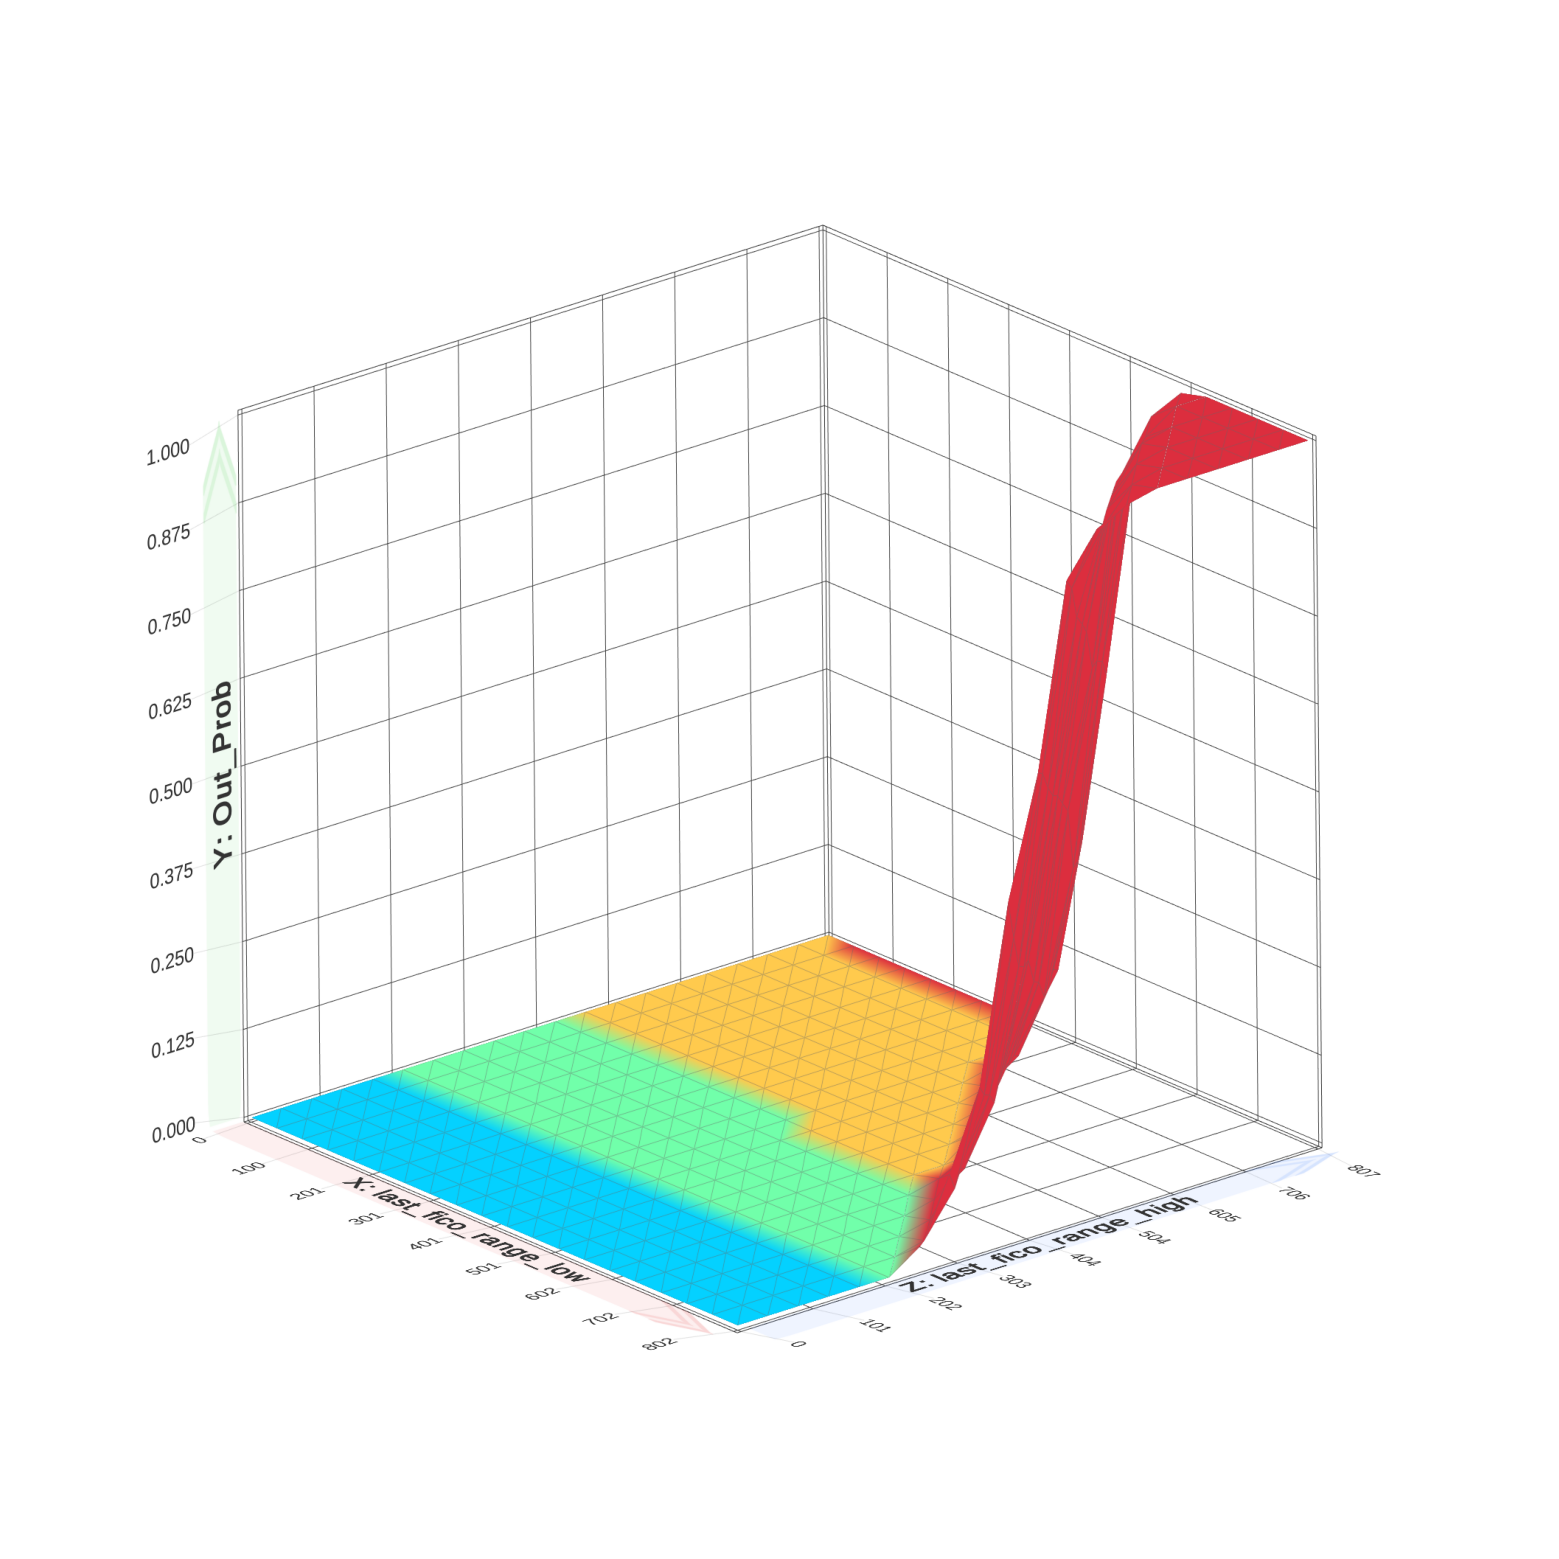

In [141]:
data=pd.read_csv('LoanClub10000Cleaned.csv')
UnNormData=pd.read_csv('LoanClub10000CleanedUnNorm.csv')
data=data.drop(columns="Unnamed: 0")
print(data)
a=feature_imp_var(data,"target")

       loan_amnt  int_rate  annual_inc       dti  delinq_2yrs  fico_range_low  \
0       0.076471  0.366286    0.006120  0.005916     0.000000        0.081081   
1       0.697059  0.281791    0.007269  0.016076     0.066667        0.297297   
2       0.558824  0.230672    0.007039  0.010791     0.000000        0.189189   
3       0.276471  0.723701    0.011803  0.025395     0.066667        0.189189   
4       0.322059  0.343050    0.003705  0.010210     0.000000        0.162162   
...          ...       ...         ...       ...          ...             ...   
35189   0.558824  0.281791    0.004970  0.031922     0.000000        0.054054   
35190   0.779412  0.281791    0.006120  0.026737     0.000000        0.378378   
35191   0.058824  0.281791    0.013592  0.017938     0.000000        0.027027   
35192   0.196324  0.873257    0.002556  0.016216     0.000000        0.081081   
35193   0.323529  0.386988    0.005315  0.032112     0.000000        0.351351   

       fico_range_high  inq

Epoch 1/5
1650/1650 [==============================] - 3s 1ms/step - loss: 0.3275 - accuracy: 0.8604 - val_loss: 0.2281 - val_accuracy: 0.9085
Epoch 2/5
1650/1650 [==============================] - 2s 1ms/step - loss: 0.2151 - accuracy: 0.9127 - val_loss: 0.2209 - val_accuracy: 0.9084
Epoch 3/5
1650/1650 [==============================] - 2s 1ms/step - loss: 0.2090 - accuracy: 0.9170 - val_loss: 0.2163 - val_accuracy: 0.9112
Epoch 4/5
1650/1650 [==============================] - 2s 1ms/step - loss: 0.2073 - accuracy: 0.9166 - val_loss: 0.2131 - val_accuracy: 0.9134
Epoch 5/5
69/69 [==============================] - 0s 1ms/step - loss: 0.2126 - accuracy: 0.9118
loan_amnt
Epoch 1/5
1650/1650 [==============================] - 3s 1ms/step - loss: 0.3150 - accuracy: 0.8698 - val_loss: 0.2261 - val_accuracy: 0.9081
Epoch 2/5
1650/1650 [==============================] - 2s 1ms/step - loss: 0.2187 - accuracy: 0.9113 - val_loss: 0.2187 - val_accuracy: 0.9082
Epoch 3/5
1650/1650 [==============

1650/1650 [==============================] - 3s 1ms/step - loss: 0.3252 - accuracy: 0.8599 - val_loss: 0.2136 - val_accuracy: 0.9106
Epoch 2/5
1650/1650 [==============================] - 2s 1ms/step - loss: 0.2166 - accuracy: 0.9130 - val_loss: 0.2203 - val_accuracy: 0.9124
Epoch 3/5
1650/1650 [==============================] - 2s 1ms/step - loss: 0.2130 - accuracy: 0.9134 - val_loss: 0.2015 - val_accuracy: 0.9179
Epoch 4/5
1650/1650 [==============================] - 2s 1ms/step - loss: 0.2114 - accuracy: 0.9153 - val_loss: 0.2032 - val_accuracy: 0.9169
Epoch 5/5
69/69 [==============================] - 0s 974us/step - loss: 0.2017 - accuracy: 0.9170
[0.2017386257648468, 0.9170360565185547]
total_rev_hi_lim
Epoch 1/5
1650/1650 [==============================] - 3s 2ms/step - loss: 0.4863 - accuracy: 0.8205 - val_loss: 0.2985 - val_accuracy: 0.9083
Epoch 2/5
1650/1650 [==============================] - 2s 1ms/step - loss: 0.2540 - accuracy: 0.9088 - val_loss: 0.2484 - val_accuracy: 0.

1650/1650 [==============================] - 3s 1ms/step - loss: 0.3240 - accuracy: 0.8485 - val_loss: 0.2169 - val_accuracy: 0.9126
Epoch 2/5
1650/1650 [==============================] - 2s 1ms/step - loss: 0.2161 - accuracy: 0.9124 - val_loss: 0.2094 - val_accuracy: 0.9153
Epoch 3/5
1650/1650 [==============================] - 2s 1ms/step - loss: 0.2107 - accuracy: 0.9145 - val_loss: 0.2275 - val_accuracy: 0.9062
Epoch 4/5
1650/1650 [==============================] - 2s 1ms/step - loss: 0.2080 - accuracy: 0.9162 - val_loss: 0.2174 - val_accuracy: 0.9098
Epoch 5/5
69/69 [==============================] - 0s 1ms/step - loss: 0.2049 - accuracy: 0.9174
[0.2048916071653366, 0.9173769950866699]
num_tl_90g_dpd_24m
Epoch 1/5
1650/1650 [==============================] - 3s 2ms/step - loss: 0.3155 - accuracy: 0.8660 - val_loss: 0.2617 - val_accuracy: 0.8974
Epoch 2/5
1650/1650 [==============================] - 2s 1ms/step - loss: 0.2147 - accuracy: 0.9121 - val_loss: 0.2055 - val_accuracy: 0.

In [129]:
def Single_var_effect(data,var,model,sam):
    minV=data[var].min()
    maxV=data[var].max()
    inp=data.head(1)
    dic={"var_value":[],"Out_node":[]}
    chart_data=pd.DataFrame(dic)
    for i in range(0,sam):
        Var_in=minV+(maxV-minV)/sam*i
#        inp=inp.iloc([[0]])
        inp[var]=Var_in
        print(inp)
        out=model.predict(inp)
        
        dic={"var_value":[Var_in],"Out_node":[out]}
        chart_data=chart_data.append(dic,ignore_index=True)
    Data_frame=pd.DataFrame(chart_data)
    return (Data_frame)

def two_var_effect_single_instance(vip,data,var1,var2,model,UnNormdata):
    minV1=data[var1].min()
    maxV1=data[var1].max()
    minV2=data[var2].min()
    maxV2=data[var2].max()
    inp=data.head(1)
    print(inp)
    dic={var1:[],var2:[],"Out_Prob":[]}
    chart_data=pd.DataFrame(dic)
    for i in range(0,20):
        Var_in2=minV1+(maxV1-minV1)/20*i
        for h in range(0,20):
            Var_in1=minV1+(maxV1-minV1)/20*h
            inp[var1]=Var_in1
            inp[var2]=Var_in2
            dic={var1:Var_in1,var2:Var_in2,"Out_Prob":model.predict(inp)[0][0]}
            chart_data=chart_data.append(dic,ignore_index=True)
    Data_frame=pd.DataFrame(chart_data)
    maxV=UnNormdata[var1].max()
    minV=UnNormdata[var1].min()
    maxV2=UnNormdata[var2].max()
    minV2=UnNormdata[var2].min()
    Data_frame2 = pd.DataFrame(0, index=np.arange(len(Data_frame)), columns=[var1,var2,"Out_Prob"])
    Data_frame2["Out_Prob"]=Data_frame["Out_Prob"]
    print(Data_frame)
    for i in range(0,len(Data_frame[var1])):
        Data_frame2[var1][i]=Data_frame[var1][i]*(maxV-minV)+minV
    for i in range(0,len(Data_frame[var1])):
        Data_frame2[var2][i]=Data_frame[var2][i]*(maxV2-minV2)+minV2
    vip.load_data(Data_frame2, "Feature Importance")
    vip.plot(plot_type="surface",x=var1,y="Out_Prob",z=var2,color='Out_Prob')

Setting up WebSocket connection to: ws://localhost:12345/api
Connection Successful! Initializing session.
   loan_amnt  int_rate  annual_inc       dti  delinq_2yrs  fico_range_low  \
0   0.076471  0.366286     0.00612  0.005916          0.0        0.081081   

   fico_range_high  inq_last_6mths  open_acc  pub_rec  ...  num_sats  \
0         0.080645             0.2  0.090909      0.0  ...  0.090909   

   num_tl_90g_dpd_24m  num_tl_op_past_12m  pct_tl_nvr_dlq  \
0                 0.0                 0.1           0.736   

   pub_rec_bankruptcies  tax_liens  tot_hi_cred_lim  total_bal_ex_mort  \
0                   0.0        0.0         0.054033           0.008816   

   total_bc_limit  total_il_high_credit_limit  
0        0.007921                    0.020898  

[1 rows x 47 columns]


<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var1]=Var_in1
<ipython-input-129-93a179f63399>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var2]=Var_in2
<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var1]=Var_in1
<ipython-input-129-93a179f63399>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var2]=Var_in2
<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var1]=Var_in1
<ipython-input-129-93a179f63399>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var2]=Var_in2
<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var1]=Var_in1
<ipython-input-129-93a179f63399>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var2]=Var_in2
<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var1]=Var_in1
<ipython-input-129-93a179f63399>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var2]=Var_in2
<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var1]=Var_in1
<ipython-input-129-93a179f63399>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var2]=Var_in2
<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var1]=Var_in1
<ipython-input-129-93a179f63399>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var2]=Var_in2
<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var1]=Var_in1
<ipython-input-129-93a179f63399>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var2]=Var_in2
<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var1]=Var_in1
<ipython-input-129-93a179f63399>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var2]=Var_in2
<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var1]=Var_in1
<ipython-input-129-93a179f63399>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var2]=Var_in2
<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var1]=Var_in1
<ipython-input-129-93a179f63399>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var2]=Var_in2
<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var1]=Var_in1
<ipython-input-129-93a179f63399>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var2]=Var_in2
<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var1]=Var_in1
<ipython-input-129-93a179f63399>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var2]=Var_in2
<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var1]=Var_in1
<ipython-input-129-93a179f63399>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var2]=Var_in2
<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var1]=Var_in1
<ipython-input-129-93a179f63399>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var2]=Var_in2
<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var1]=Var_in1
<ipython-input-129-93a179f63399>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var2]=Var_in2
<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var1]=Var_in1
<ipython-input-129-93a179f63399>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var2]=Var_in2
<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var1]=Var_in1
<ipython-input-129-93a179f63399>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var2]=Var_in2
<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var1]=Var_in1
<ipython-input-129-93a179f63399>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var2]=Var_in2
<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var1]=Var_in1
<ipython-input-129-93a179f63399>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var2]=Var_in2
<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var1]=Var_in1
<ipython-input-129-93a179f63399>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var2]=Var_in2
<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var1]=Var_in1
<ipython-input-129-93a179f63399>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var2]=Var_in2
<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var1]=Var_in1
<ipython-input-129-93a179f63399>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var2]=Var_in2
<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var1]=Var_in1
<ipython-input-129-93a179f63399>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var2]=Var_in2
<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var1]=Var_in1
<ipython-input-129-93a179f63399>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var2]=Var_in2
<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var1]=Var_in1
<ipython-input-129-93a179f63399>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var2]=Var_in2
<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var1]=Var_in1
<ipython-input-129-93a179f63399>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var2]=Var_in2
<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var1]=Var_in1
<ipython-input-129-93a179f63399>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var2]=Var_in2
<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var1]=Var_in1
<ipython-input-129-93a179f63399>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var2]=Var_in2
<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var1]=Var_in1
<ipython-input-129-93a179f63399>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var2]=Var_in2
<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var1]=Var_in1
<ipython-input-129-93a179f63399>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var2]=Var_in2
<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var1]=Var_in1
<ipython-input-129-93a179f63399>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp[var2]=Var_in2
<ipython-input-129-93a179f63399>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

     fico_range_high  loan_amnt  Out_Prob
0               0.00       0.00  0.648140
1               0.05       0.00  0.643432
2               0.10       0.00  0.636883
3               0.15       0.00  0.630195
4               0.20       0.00  0.623397
..               ...        ...       ...
395             0.75       0.95  0.168809
396             0.80       0.95  0.171064
397             0.85       0.95  0.173344
398             0.90       0.95  0.175651
399             0.95       0.95  0.177983

[400 rows x 3 columns]


<ipython-input-129-93a179f63399>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data_frame2[var1][i]=Data_frame[var1][i]*(maxV-minV)+minV
<ipython-input-129-93a179f63399>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data_frame2[var2][i]=Data_frame[var2][i]*(maxV2-minV2)+minV2


Data set loaded with name: 'Feature Importance (14)'




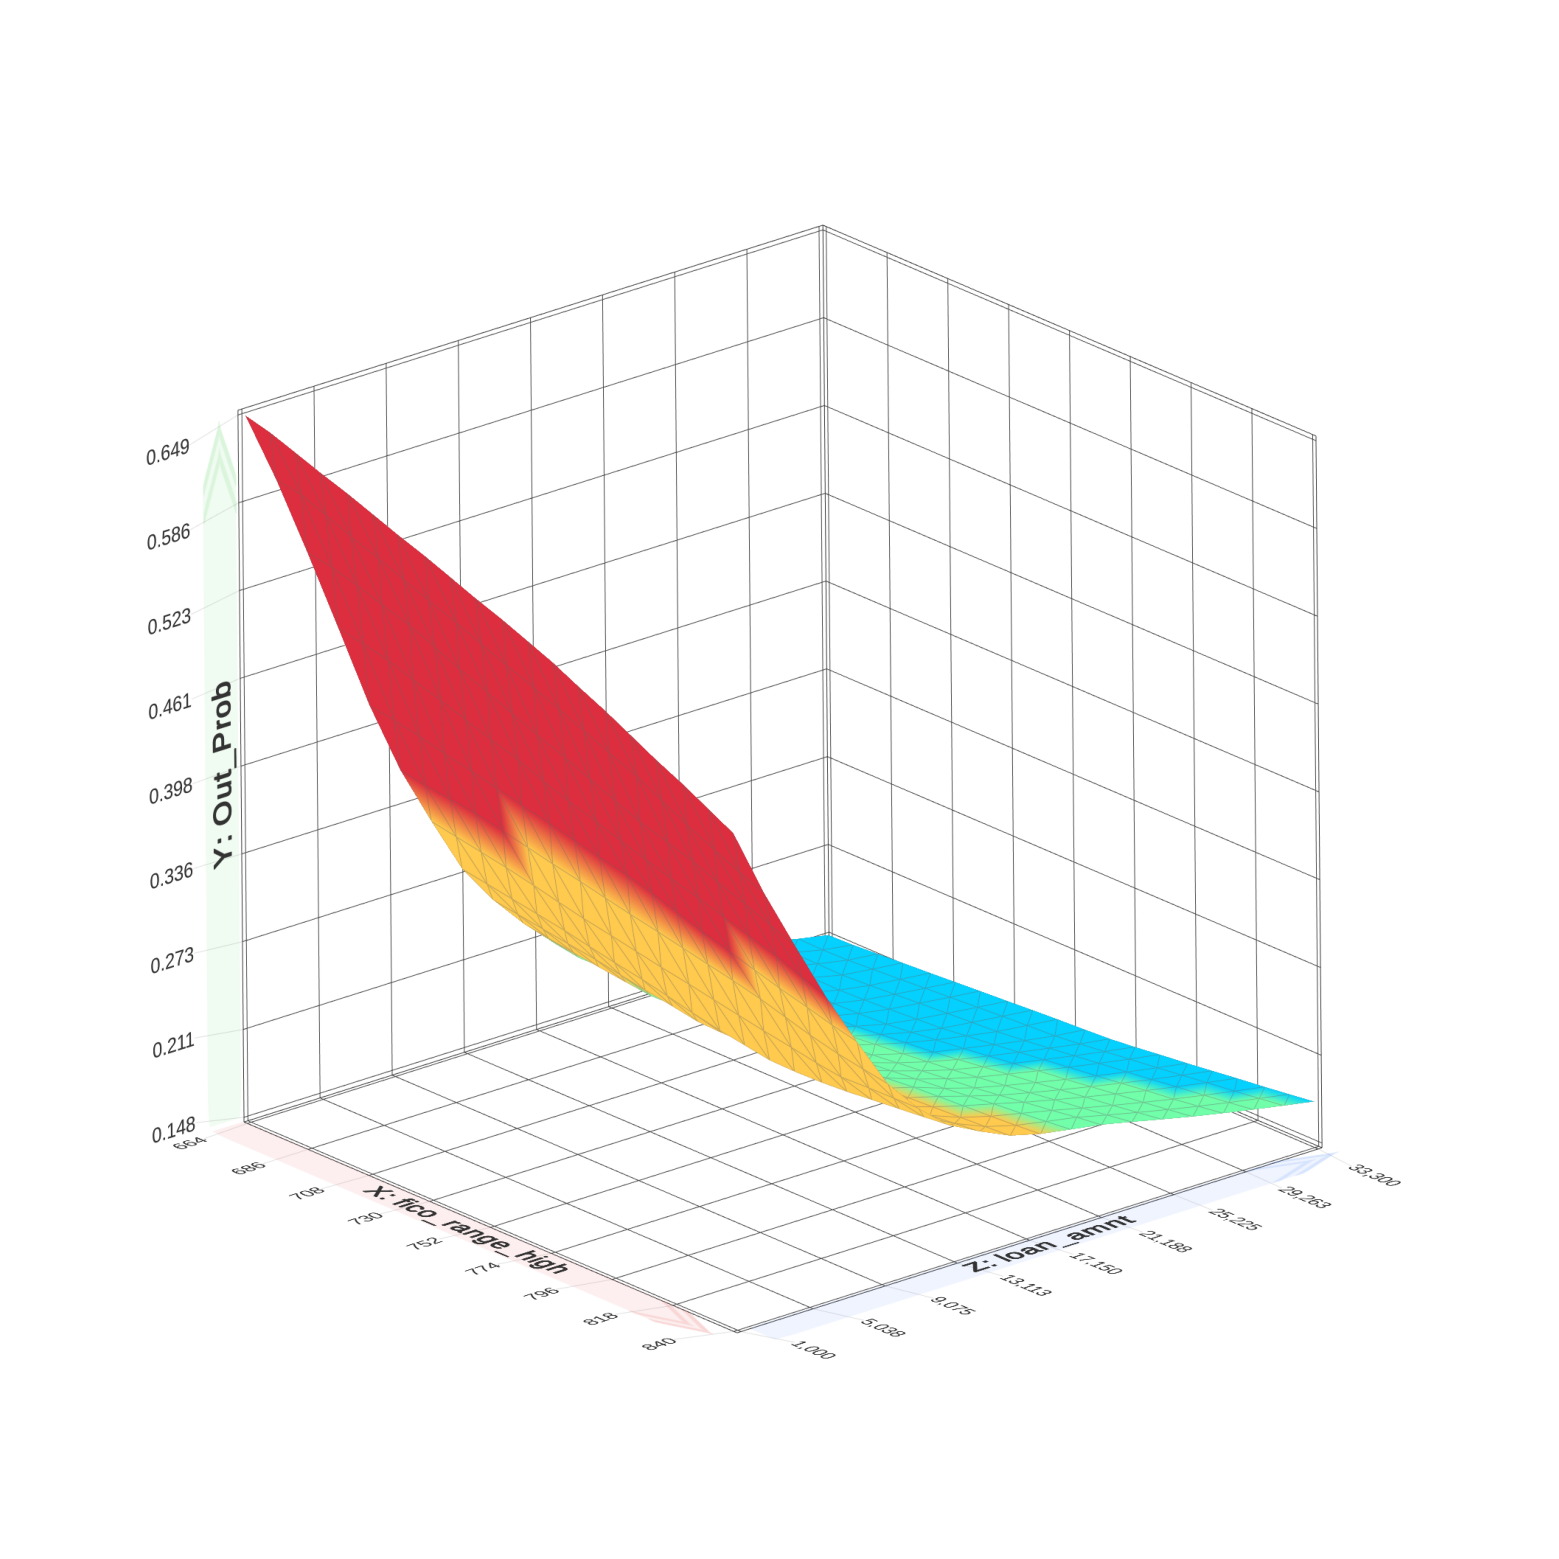

In [137]:
import os, sys, psutil, gc, tensorflow
import numpy as np
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn import preprocessing
import pandas as pd
import pandas
from virtualitics import api
import pandas as pd
data=pd.read_csv('LoanClub10000Cleaned.csv')
UnNormdata=pd.read_csv('LoanClub10000CleanedUnNorm.csv')
data=data.drop(columns="Unnamed: 0")
data=data.drop(columns="target")
vip = api.VIP()
two_var_effect_single_instance(vip,data,"fico_range_high","loan_amnt",model,UnNormData)

In [136]:
print(a)

                           var     Imp
21                 avg_cur_bal  0.1123
25       mo_sin_rcnt_rev_tl_op  0.0150
12        last_fico_range_high  0.0123
43             tot_hi_cred_lim  0.0109
38          num_tl_90g_dpd_24m  0.0109
17                tot_coll_amt  0.0104
8                     open_acc  0.0098
5               fico_range_low  0.0088
9                      pub_rec  0.0072
20        acc_open_past_24mths  0.0071
40              pct_tl_nvr_dlq  0.0069
41        pub_rec_bankruptcies  0.0068
1                     int_rate  0.0063
27                    mort_acc  0.0045
37                    num_sats  0.0038
0                    loan_amnt  0.0029
42                   tax_liens  0.0019
31                 num_bc_sats -0.0001
6              fico_range_high -0.0001
10                   revol_bal -0.0002
7               inq_last_6mths -0.0005
2                   annual_inc -0.0005
46  total_il_high_credit_limit -0.0010
26              mo_sin_rcnt_tl -0.0016
32                   num_

In [1]:
print(a)

NameError: name 'a' is not defined